In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
from torch.utils.data import TensorDataset

In [3]:
def create_balanced_val_set(dataset, val_size=0.2):
  num_samples = len(dataset)
  labels = [[] for _ in range(10)]   
  for i in range(num_samples):
    _, label = dataset[i]
    labels[label].append(i)   
  val_indices = []
  for label in labels:
    val_count = int(len(label) * val_size)   
    val_indices.extend(random.sample(label, val_count))   
  train_indices = [i for i in range(num_samples) if i not in val_indices]  
  return torch.utils.data.Subset(dataset, train_indices), torch.utils.data.Subset(dataset, val_indices)



In [4]:
batch_size = 128


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_set, val_set = create_balanced_val_set(trainset)

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:11<00:00, 14210966.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### part a

In [5]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')  

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device_)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


In [6]:
def evaluate_model(model, criterion, test_loader, device):


  model.to(device)

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  return accuracy

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20, device="cpu"):

  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  model.to(device)

  for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, train_data in enumerate(train_loader, 0):
      train_inputs, train_labels = train_data[0].to(device), train_data[1].to(device)
      optimizer.zero_grad()

      train_outputs = model(train_inputs)
      train_loss = criterion(train_outputs, train_labels)
      train_loss.backward()
      optimizer.step()

      train_running_loss += train_loss.item()

      _, train_predicted = torch.max(train_outputs.data, 1)
      train_total += train_labels.size(0)
      train_correct += (train_predicted == train_labels).sum().item()

    train_epoch_loss = train_running_loss / len(train_loader)
    train_loss_history.append(train_epoch_loss)
    train_accuracy = train_correct / train_total
    train_acc_history.append(train_accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}] Train Loss: {train_epoch_loss:.3f}, Accuracy: {train_accuracy:.3f}%')

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for val_data in val_loader:
        val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item()

        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader)
    val_loss_history.append(val_epoch_loss)
    val_accuracy = val_correct / val_total
    val_acc_history.append(val_accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}] Validation Loss: {val_epoch_loss:.3f}, Accuracy: {val_accuracy:.3f}%')

  return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


model, a_origin_loss, a_origin_acc, a_origin_loss_val, a_origin_acc_val  = train_model(model, optimizer, criterion, trainloader, valloader, epochs=10, device=device_)

Epoch [1/10] Train Loss: 0.887, Accuracy: 0.700%
Epoch [1/10] Validation Loss: 0.722, Accuracy: 0.745%
Epoch [2/10] Train Loss: 0.568, Accuracy: 0.809%
Epoch [2/10] Validation Loss: 0.432, Accuracy: 0.853%
Epoch [3/10] Train Loss: 0.441, Accuracy: 0.852%
Epoch [3/10] Validation Loss: 0.333, Accuracy: 0.888%
Epoch [4/10] Train Loss: 0.345, Accuracy: 0.882%
Epoch [4/10] Validation Loss: 0.267, Accuracy: 0.911%
Epoch [5/10] Train Loss: 0.270, Accuracy: 0.909%
Epoch [5/10] Validation Loss: 0.153, Accuracy: 0.951%
Epoch [6/10] Train Loss: 0.213, Accuracy: 0.927%
Epoch [6/10] Validation Loss: 0.153, Accuracy: 0.946%
Epoch [7/10] Train Loss: 0.176, Accuracy: 0.940%
Epoch [7/10] Validation Loss: 0.105, Accuracy: 0.967%
Epoch [8/10] Train Loss: 0.152, Accuracy: 0.949%
Epoch [8/10] Validation Loss: 0.089, Accuracy: 0.971%
Epoch [9/10] Train Loss: 0.117, Accuracy: 0.961%
Epoch [9/10] Validation Loss: 0.089, Accuracy: 0.970%
Epoch [10/10] Train Loss: 0.104, Accuracy: 0.965%
Epoch [10/10] Validatio

In [7]:
import matplotlib.pyplot as plt

def plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history, title="Training History"):


  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_loss_history) + 1)
  
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss_history, label='Training Loss')
  plt.plot(epochs, val_loss_history, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc_history, label='Training Accuracy')
  plt.plot(epochs, val_acc_history, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


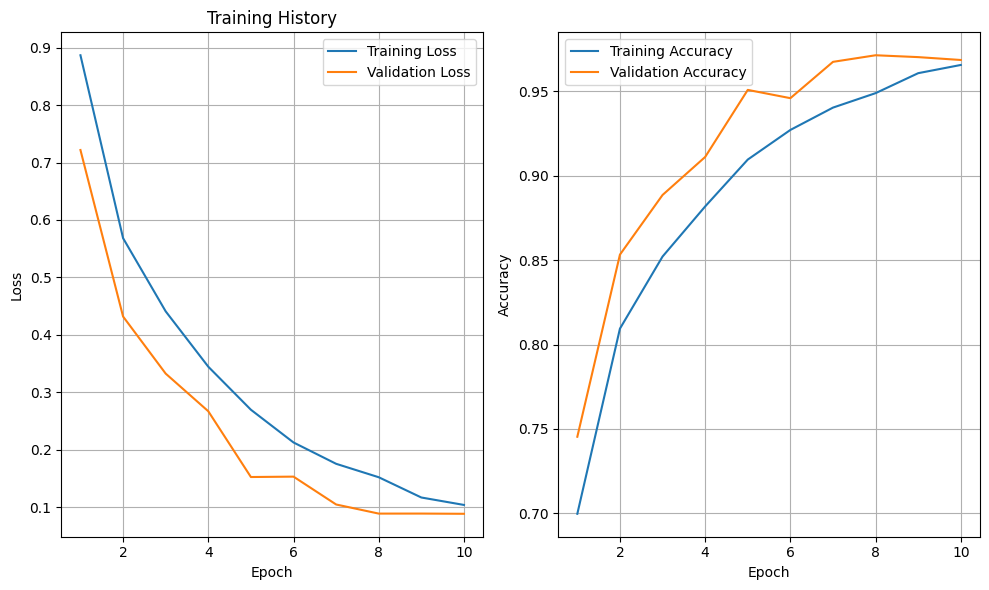

In [8]:
plot_history(a_origin_loss, a_origin_acc, a_origin_loss_val, a_origin_acc_val, title="Training History")

In [9]:
def create_embeddings(model, data_loader, device="cpu"):
    embeddings = []
    labels = []
    
    model.eval()
    try:
        with torch.no_grad():
            for inputs, target in data_loader:

                inputs = inputs.to(device)
                output = model(inputs)
                embeddings.extend(output.cpu().numpy())
                labels.extend(target.cpu().numpy())

        return embeddings, labels
    except:
        with torch.no_grad():
            for inputs in data_loader:

                inputs = inputs.to(device)
                output = model(inputs)
                embeddings.extend(output.cpu().numpy())
        return embeddings
import umap



2024-04-14 10:56:28.847800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 10:56:28.847913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 10:56:28.958209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def visualize_features(features, labels):
    umap_reducer = umap.UMAP(n_components=2)
    umap_embedding = umap_reducer.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels, cmap='viridis',s=7)
    plt.colorbar(label='Classes')
    plt.title('2D Visualization of Features using UMAP')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Compyonent 2')
    plt.grid(True)
    plt.show()
    

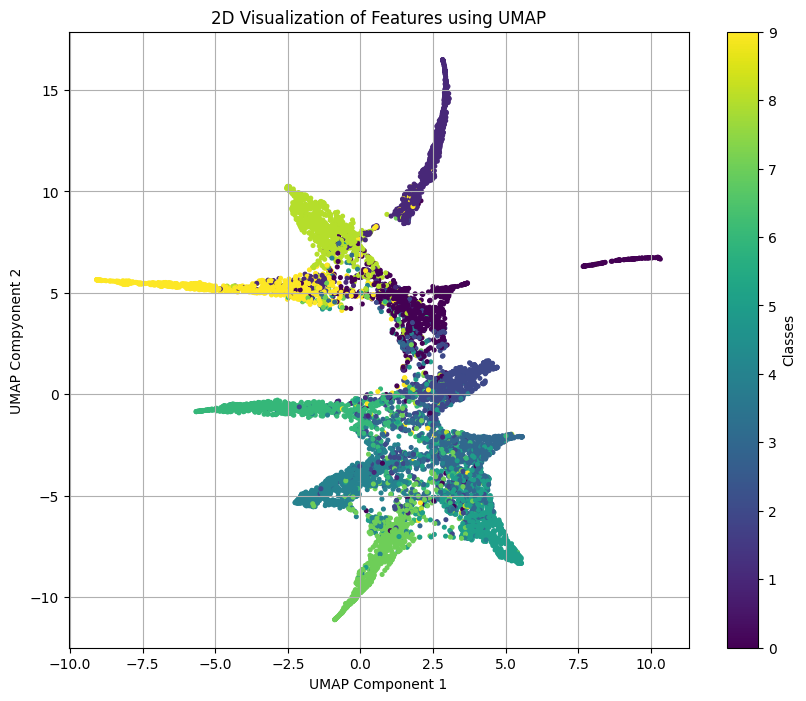

In [11]:
embeddings, labels = create_embeddings(torch.nn.Sequential(*list(model.children())[:-1]), testloader,device=device_)
embeddings_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings]
visualize_features(embeddings_reshaped, labels)


In [12]:
def fgsm_attack_white_noise(model, loss_fn, dataloader, epsilon, noise_percentage=0.03):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)  
    
    original_images = []
    adversarial_images = []
    labels = []
    predicted_labels = []

    for images, labels_batch in dataloader:
        images = images.to(device)   
        labels_batch = labels_batch.to(device)   

        images.requires_grad = True  
        outputs = model(images)
        loss = loss_fn(outputs, labels_batch)

 
        model.zero_grad()
        loss.backward()
        grad = images.grad.data


        adv_image = images.data + epsilon * torch.sign(grad)


        noise_mask = torch.rand(images.shape).to(device) < noise_percentage  
        noise = torch.rand_like(images).to(device)   
        adv_image = torch.where(noise_mask, noise, adv_image)   

        original_images.append(images.cpu())   
        adversarial_images.append(adv_image.cpu())  
        labels.append(labels_batch.cpu())   


        adv_outputs = model(adv_image)
        _, predicted = torch.max(adv_outputs, 1)
        predicted_labels.append(predicted.cpu())


    original_images = torch.cat(original_images)
    adversarial_images = torch.cat(adversarial_images)
    labels = torch.cat(labels)
    predicted_labels = torch.cat(predicted_labels)

    return original_images, adversarial_images, labels, predicted_labels


In [13]:
def show_images(original_images, adversarial_images, labels, predicted_labels, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 2 * num_samples))
    
    for i in range(num_samples):

        axes[i, 0].imshow(original_images[i].detach().cpu().permute(1, 2, 0))
        axes[i, 0].set_title(f"Original\nLabel: {labels[i]}")
        axes[i, 0].axis('off')
        

        axes[i, 1].imshow(adversarial_images[i].detach().cpu().permute(1, 2, 0))
        axes[i, 1].set_title(f"Adversarial\npredicted Label: {predicted_labels[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

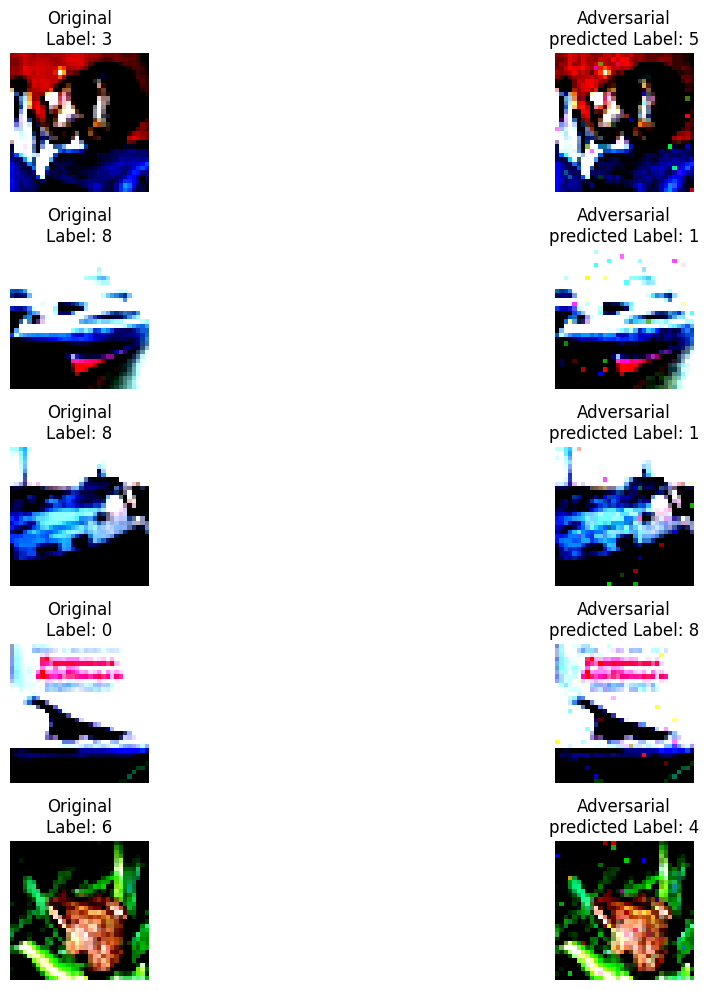

In [20]:
original_images, adversarial_images, labels, predicted_labels = fgsm_attack_white_noise(model, criterion, testloader, 0.1, 0.01)
show_images(original_images, adversarial_images, labels, predicted_labels)

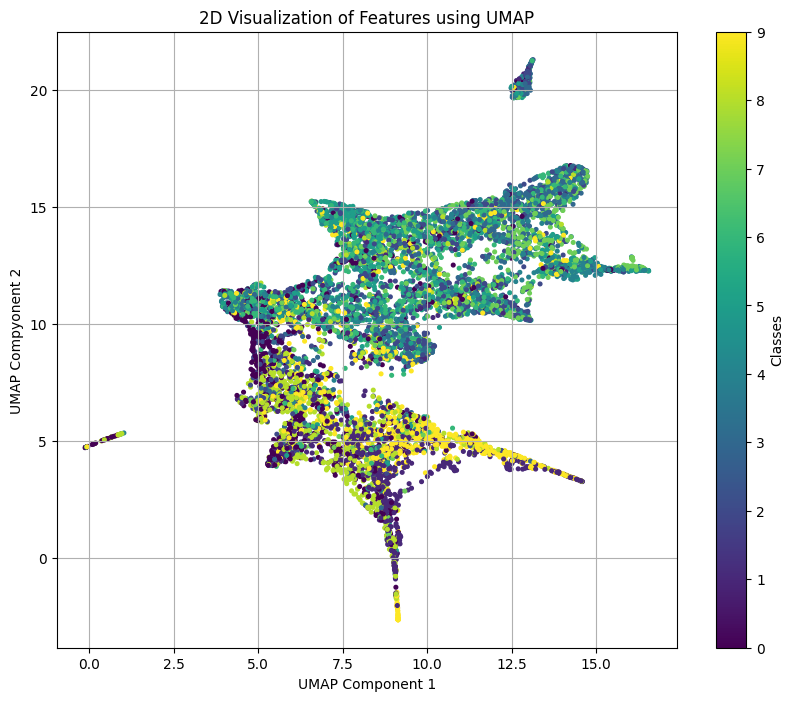

In [15]:

data_loader_adv = DataLoader(adversarial_images, batch_size=batch_size, shuffle=False)
embeddings_adv = create_embeddings(torch.nn.Sequential(*list(model.children())[:-1]), data_loader_adv,device=device_)
embeddings_adv_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_adv]
visualize_features(embeddings_adv_reshaped, labels)



In [16]:
from sklearn.neighbors import KNeighborsClassifier

def train_and_evaluate_knn(features_train, label_train, features_test, adv_features_test, label_test, k):

  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(features_train, label_train)

  accuracy_adv = knn_classifier.score(adv_features_test, label_test)
  accuracy_clean = knn_classifier.score(features_test, label_test)

  return knn_classifier, {'clean_accuracy': accuracy_clean, 'adv_accuracy': accuracy_adv}

In [38]:
embeddings_train, label_train = create_embeddings(torch.nn.Sequential(*list(model.children())[:-1]), trainloader,device=device_)
embeddings_train_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_train]

embeddings_test, label_test = create_embeddings(torch.nn.Sequential(*list(model.children())[:-1]), testloader,device=device_)
embeddings_test_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_test]

data_loader_adv = DataLoader(adversarial_images, batch_size=batch_size, shuffle=False)
embeddings_adv = create_embeddings(torch.nn.Sequential(*list(model.children())[:-1]), data_loader_adv,device=device_)
embeddings_adv_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_adv]


In [39]:
k = 5
knn_classifier, accuracies = train_and_evaluate_knn(embeddings_train_reshaped, label_train, embeddings_test_reshaped, embeddings_adv_reshaped, label_test, k)

print("KNN Classifier Trained")
print(f"Accuracy on clean data: {accuracies['clean_accuracy']}")
print(f"Accuracy on adversarial data: {accuracies['adv_accuracy']}")

KNN Classifier Trained
Accuracy on clean data: 0.8112
Accuracy on adversarial data: 0.1836


### part b

In [40]:
import random

def fgsm_attack_batch(inputs, labels, model, criterion, epsilon, noise_percentage, device):
    inputs.requires_grad = True
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    grad = inputs.grad.data


    perturbation = epsilon * torch.sign(grad)


    noise = torch.zeros_like(inputs).uniform_()   
    noise_mask = torch.rand(noise.shape) < noise_percentage   
    noise[noise_mask] = 1   
    perturbation += noise


    adv_inputs = inputs + perturbation
    adv_inputs = torch.clamp(adv_inputs, 0, 1)  
    
    inputs.grad.zero_()

    return adv_inputs, labels

def train_model_with_random_fgsm(model, optimizer, criterion, train_loader, val_loader, fgsm_epsilon, epochs=20, device="cpu"):

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    model.to(device)
    noise_percentage = 0.01
    for epoch in range(epochs):

        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, train_data in enumerate(train_loader, 0):

            use_adversarial = random.random() > 0.5


            inputs, labels = train_data[0].to(device), train_data[1].to(device)
            if use_adversarial:
                inputs, labels = fgsm_attack_batch(inputs, labels, model, criterion, epsilon, noise_percentage, device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_epoch_loss = train_running_loss / len(train_loader)
        train_loss_history.append(train_epoch_loss)
        train_accuracy = train_correct / train_total
        train_acc_history.append(train_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Train Loss: {train_epoch_loss:.3f}, Accuracy: {train_accuracy:.3f}%')

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_loss_history.append(val_epoch_loss)
        val_accuracy = val_correct / val_total
        val_acc_history.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{epochs}] Validation Loss: {val_epoch_loss:.3f}, Accuracy: {val_accuracy:.3f}%')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [41]:
model_b = models.resnet18(weights='ResNet18_Weights.DEFAULT')  

num_ftrs = model_b.fc.in_features
model_b.fc = nn.Linear(num_ftrs, 10)
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_b.to(device_)
optimizer = optim.Adam(model_b.parameters(), lr=0.001)


In [42]:
model_b, b_origin_loss, b_origin_acc, b_origin_loss_val, b_origin_acc_val  = train_model_with_random_fgsm(model_b, optimizer, criterion, trainloader, valloader,fgsm_epsilon = 0.1, epochs=10, device=device_)

Epoch [1/10] Train Loss: 1.310, Accuracy: 0.537%
Epoch [1/10] Validation Loss: 0.864, Accuracy: 0.697%
Epoch [2/10] Train Loss: 1.048, Accuracy: 0.626%
Epoch [2/10] Validation Loss: 0.750, Accuracy: 0.748%
Epoch [3/10] Train Loss: 0.931, Accuracy: 0.669%
Epoch [3/10] Validation Loss: 0.549, Accuracy: 0.826%
Epoch [4/10] Train Loss: 0.807, Accuracy: 0.711%
Epoch [4/10] Validation Loss: 0.518, Accuracy: 0.834%
Epoch [5/10] Train Loss: 0.748, Accuracy: 0.733%
Epoch [5/10] Validation Loss: 0.368, Accuracy: 0.881%
Epoch [6/10] Train Loss: 0.653, Accuracy: 0.768%
Epoch [6/10] Validation Loss: 0.350, Accuracy: 0.885%
Epoch [7/10] Train Loss: 0.618, Accuracy: 0.781%
Epoch [7/10] Validation Loss: 0.343, Accuracy: 0.891%
Epoch [8/10] Train Loss: 0.556, Accuracy: 0.804%
Epoch [8/10] Validation Loss: 0.244, Accuracy: 0.931%
Epoch [9/10] Train Loss: 0.498, Accuracy: 0.826%
Epoch [9/10] Validation Loss: 0.226, Accuracy: 0.931%
Epoch [10/10] Train Loss: 0.447, Accuracy: 0.844%
Epoch [10/10] Validatio

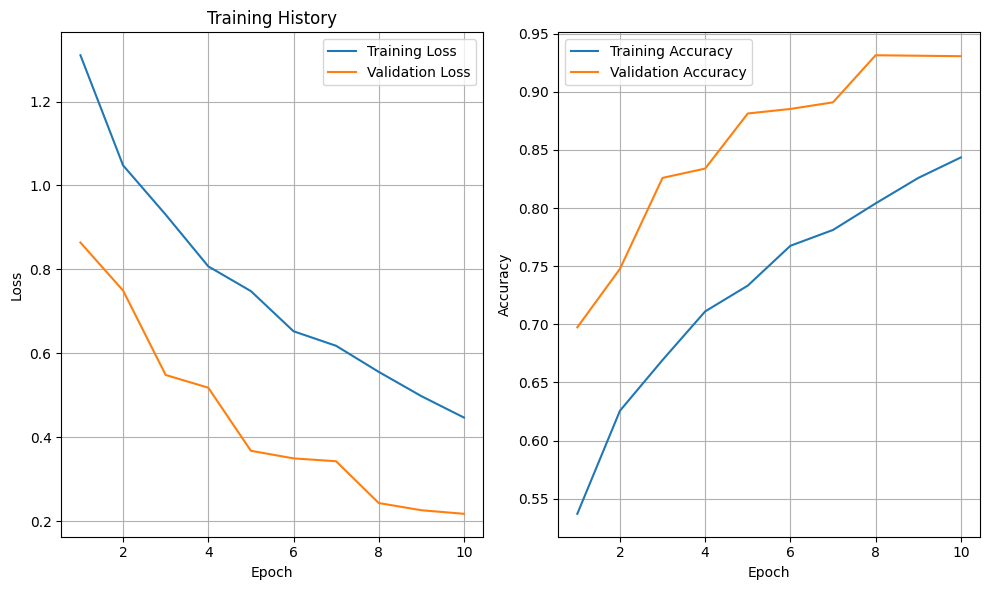

In [43]:
plot_history(b_origin_loss, b_origin_acc, b_origin_loss_val, b_origin_acc_val, title="Training History")

In [44]:
embeddings_b, labels = create_embeddings(torch.nn.Sequential(*list(model_b.children())[:-1]), testloader,device=device_)

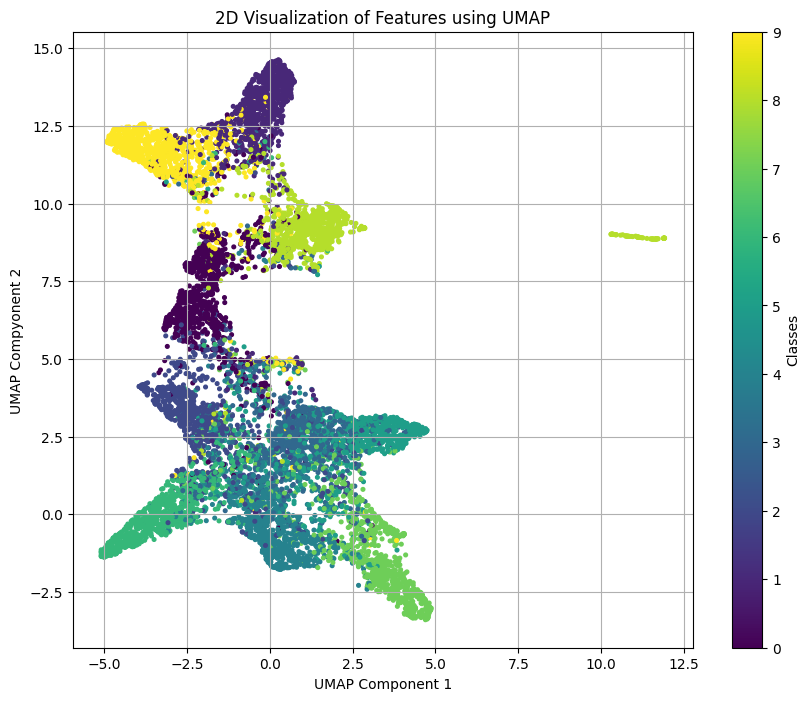

In [45]:
embeddings_b_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_b]
visualize_features(embeddings_b_reshaped, labels)

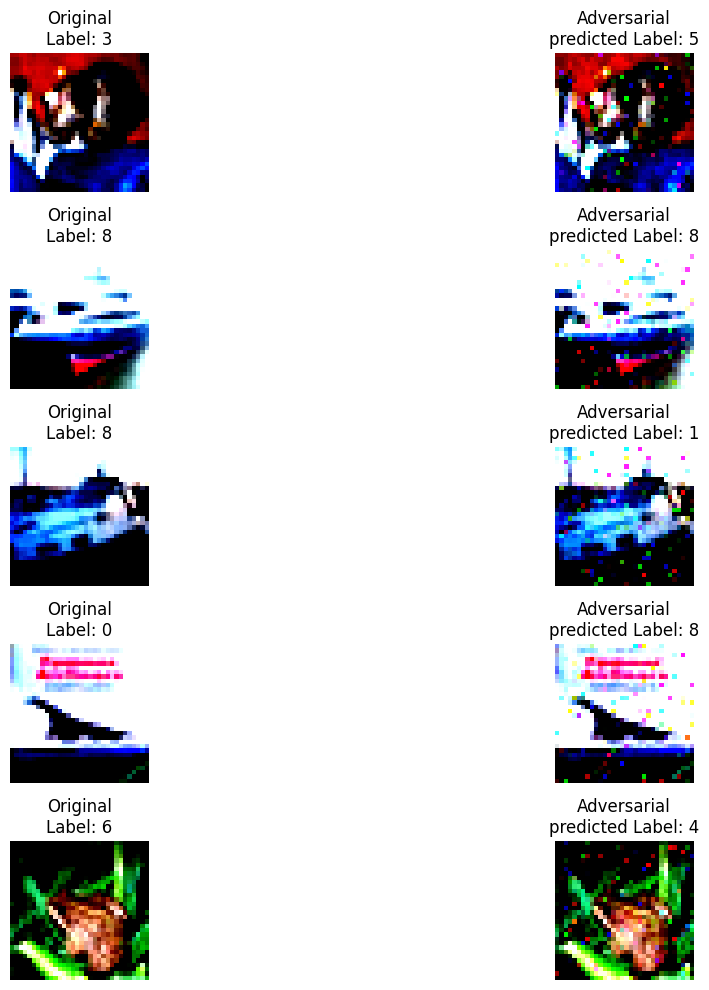

In [50]:
original_images, adversarial_images_b, labels, predicted_labels_b = fgsm_attack_white_noise(model_b, criterion, testloader, 0.1, 0.03)
show_images(original_images, adversarial_images_b, labels, predicted_labels_b)

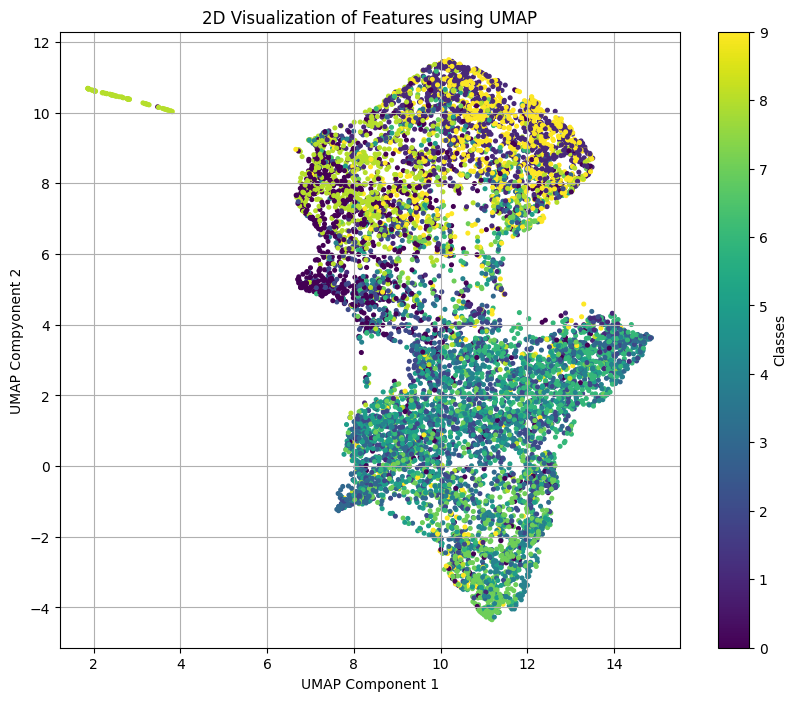

In [63]:
data_loader_adv_b = DataLoader(adversarial_images_b, batch_size=batch_size, shuffle=False)
embeddings_adv_b = create_embeddings(torch.nn.Sequential(*list(model_b.children())[:-1]), data_loader_adv_b,device=device_)
embeddings_adv_reshaped_b = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_adv_b]
visualize_features(embeddings_adv_reshaped_b, labels)

In [64]:
embeddings_train, label_train = create_embeddings(torch.nn.Sequential(*list(model_b.children())[:-1]), trainloader,device=device_)
embeddings_train_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_train]

embeddings_test, label_test = create_embeddings(torch.nn.Sequential(*list(model_b.children())[:-1]), testloader,device=device_)
embeddings_test_reshaped = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_test]

data_loader_adv_b = DataLoader(adversarial_images_b, batch_size=batch_size, shuffle=False)
embeddings_adv_b = create_embeddings(torch.nn.Sequential(*list(model_b.children())[:-1]), data_loader_adv_b,device=device_)
embeddings_adv_reshaped_b = [np.squeeze(arr, axis=(1, 2)) for arr in embeddings_adv_b]


In [65]:
k = 5
knn_classifier, accuracies = train_and_evaluate_knn(embeddings_train_reshaped, label_train, embeddings_test_reshaped, embeddings_adv_reshaped_b, label_test, k)

print("KNN Classifier Trained")
print(f"Accuracy on clean data: {accuracies['clean_accuracy']}")
print(f"Accuracy on adversarial data: {accuracies['adv_accuracy']}")

KNN Classifier Trained
Accuracy on clean data: 0.7998
Accuracy on adversarial data: 0.3103


### part c

In [77]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class NormalizedResNet18(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(NormalizedResNet18, self).__init__()
        self.base_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)

    def forward(self, x):
        features = self.base_model(x)
        normalized_features = F.normalize(features, p=2, dim=1)
        return normalized_features

model_c = NormalizedResNet18()


In [69]:
!pip install pytorch_metric_learning

In [68]:
from pytorch_metric_learning import losses


In [80]:
device_ = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_c.to(device_)
# Define loss function and optimizer
criterion_c = criterion = losses.CircleLoss(m=0.5, gamma=20)
optimizer_c = optim.Adam(model_c.parameters(), lr=0.001)


In [82]:
model_c, a_origin_loss, a_origin_acc, a_origin_loss_val, a_origin_acc_val  = train_model(model_c, optimizer_c, criterion_c, trainloader, valloader, epochs=10, device=device_)

Epoch [1/10] Train Loss: 8.459, Accuracy: 0.000%
Epoch [1/10] Validation Loss: 0.983, Accuracy: 0.000%
Epoch [2/10] Train Loss: 7.959, Accuracy: 0.000%
Epoch [2/10] Validation Loss: 0.934, Accuracy: 0.000%
Epoch [3/10] Train Loss: 7.521, Accuracy: 0.000%
Epoch [3/10] Validation Loss: 0.873, Accuracy: 0.000%
Epoch [4/10] Train Loss: 7.184, Accuracy: 0.000%
Epoch [4/10] Validation Loss: 0.800, Accuracy: 0.000%
Epoch [5/10] Train Loss: 6.837, Accuracy: 0.000%
Epoch [5/10] Validation Loss: 0.750, Accuracy: 0.000%
Epoch [6/10] Train Loss: 6.499, Accuracy: 0.000%
Epoch [6/10] Validation Loss: 0.754, Accuracy: 0.000%
Epoch [7/10] Train Loss: 6.169, Accuracy: 0.000%
Epoch [7/10] Validation Loss: 0.700, Accuracy: 0.000%
Epoch [8/10] Train Loss: 5.865, Accuracy: 0.000%
Epoch [8/10] Validation Loss: 0.626, Accuracy: 0.000%
Epoch [9/10] Train Loss: 5.522, Accuracy: 0.000%
Epoch [9/10] Validation Loss: 0.595, Accuracy: 0.000%
Epoch [10/10] Train Loss: 5.177, Accuracy: 0.000%
Epoch [10/10] Validatio

In [83]:
import matplotlib.pyplot as plt

def plot_history_c(train_loss_history, val_loss_history, title="Training History"):

  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_loss_history) + 1)
  
  plt.plot(epochs, train_loss_history, label='Training Loss')
  plt.plot(epochs, val_loss_history, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


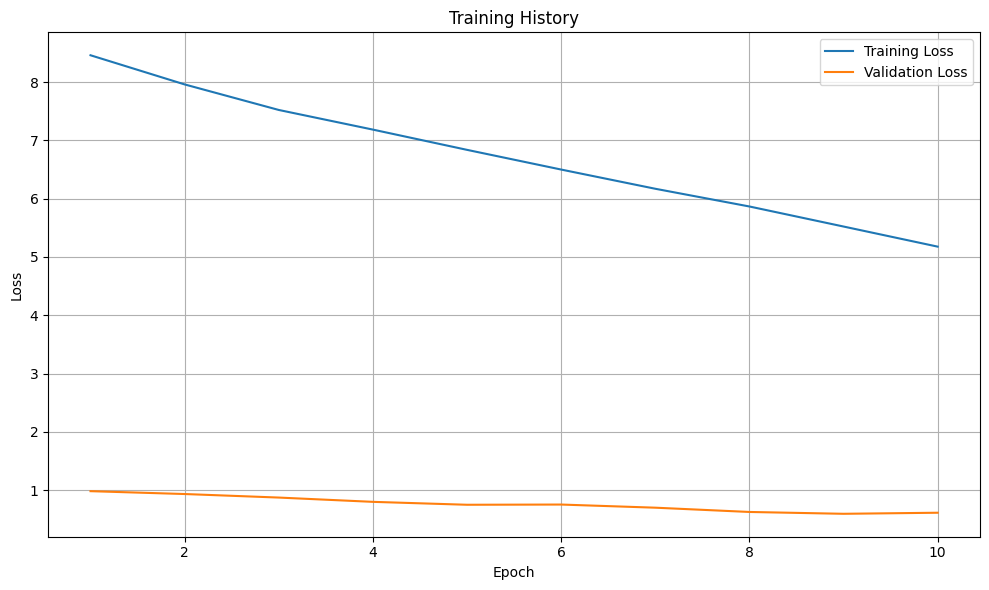

In [84]:
plot_history_c(a_origin_loss, a_origin_loss_val, title="Training History")

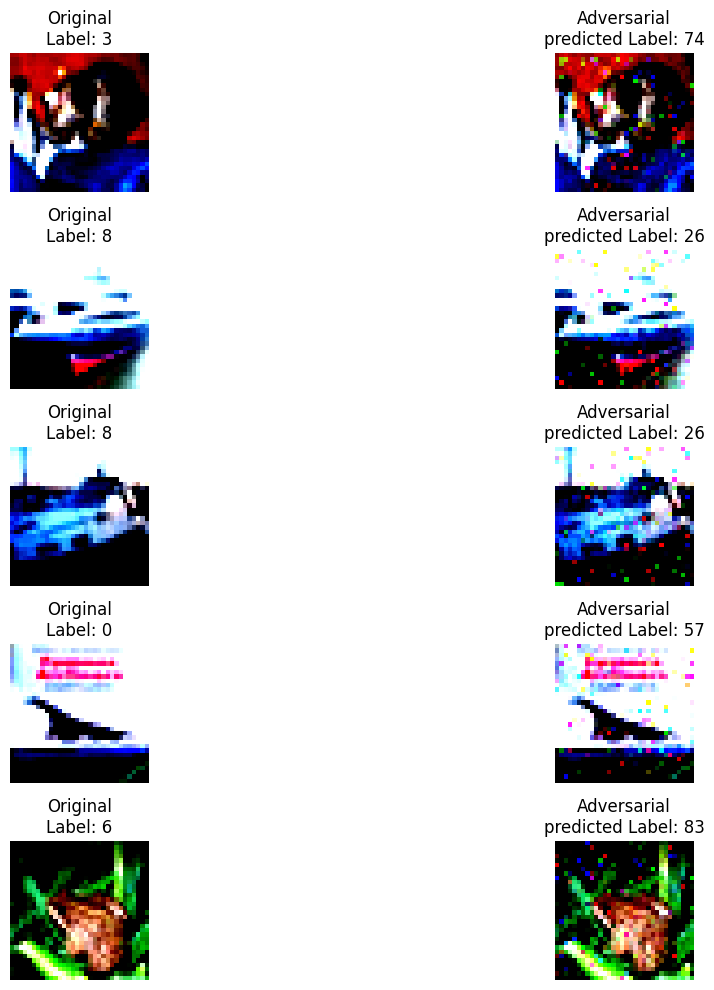

In [85]:
original_images, adversarial_images_c, labels, predicted_labels_c = fgsm_attack_white_noise(model_c, criterion_c, testloader, 0.1, 0.03)
show_images(original_images, adversarial_images_c, labels, predicted_labels_c)

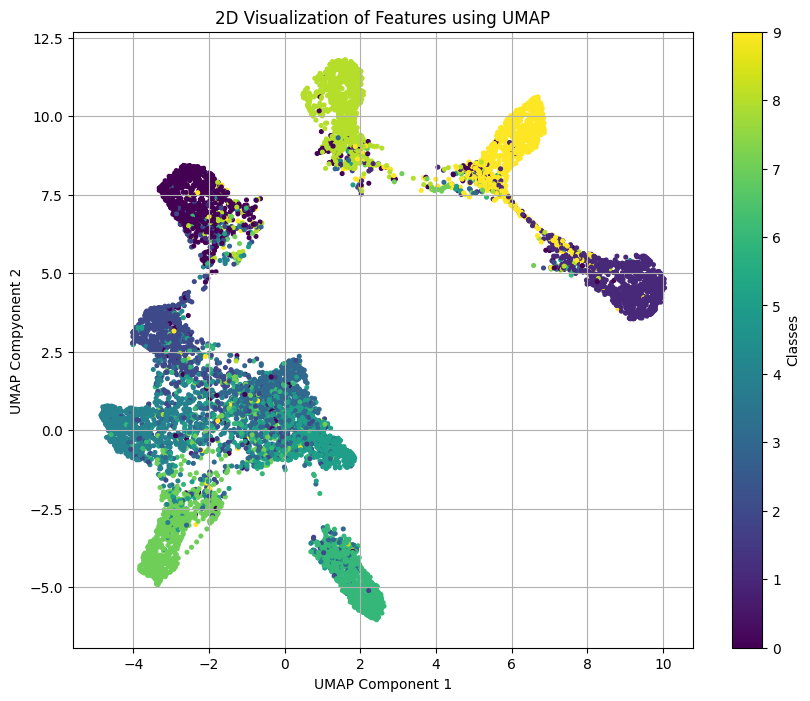

In [103]:
embeddings_test_c, labels = create_embeddings(model_c, testloader,device=device_)
visualize_features(embeddings_test_c, labels)

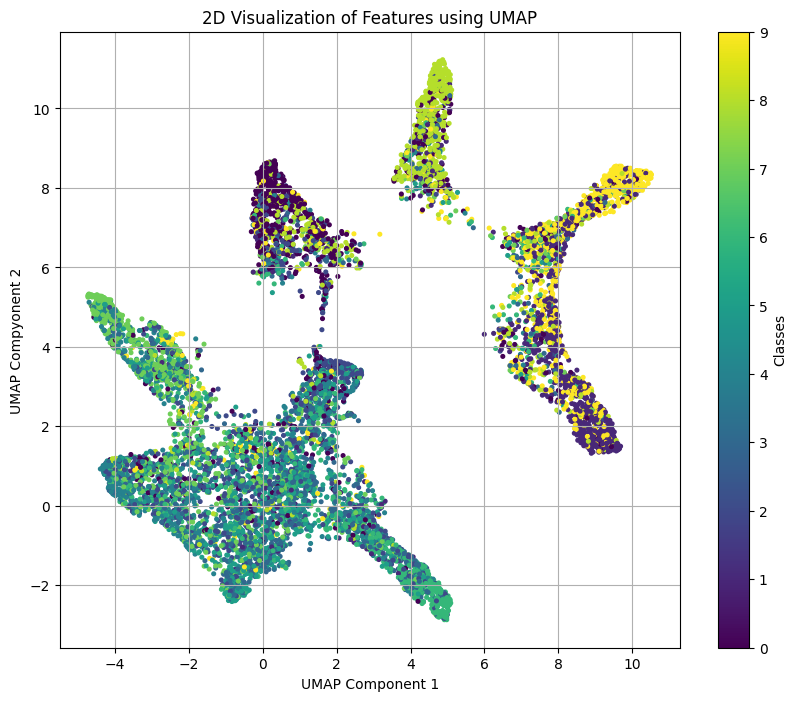

In [102]:
data_loader_adv_c = DataLoader(adversarial_images_c, batch_size=batch_size, shuffle=False)
embeddings_adv_c = create_embeddings(model_c, data_loader_adv_c,device=device_)
visualize_features(embeddings_adv_c, labels)

In [107]:
embeddings_train_c, label_train = create_embeddings(model_c, trainloader,device=device_)

_, label_test = create_embeddings(model_c, testloader,device=device_)

In [108]:
k = 5
knn_classifier, accuracies = train_and_evaluate_knn(embeddings_train_c, label_train, embeddings_test_c, embeddings_adv_c, label_test, k)

print("KNN Classifier Trained")
print(f"Accuracy on clean data: {accuracies['clean_accuracy']}")
print(f"Accuracy on adversarial data: {accuracies['adv_accuracy']}")

KNN Classifier Trained
Accuracy on clean data: 0.7905
Accuracy on adversarial data: 0.4216
